# Inference on Faas Model



First we are going to import basic packages.

In [1]:
# MATH
import numpy as np
import torch

# VISUALIZATION
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
import sbi
import sbi.utils as utils
from sbi.inference.snpe.snpe_c import SnpeC

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'figure.max_open_warning': 0})

## Different required components

Before running inference, let us define the different required components:

1. observed data
2. simulator
4. prior over model parameters

In [3]:
from faas_helper_fns import simulator

Putting the input current and the simulator together:

In [4]:
def run_faas_model(params):
    
    params = np.asarray(params)
    
    states = simulator(th=params, seed=1)
    t = np.genfromtxt('data/time_points.csv', delimiter=',')
    
    return {'data': states,
            'time': t}

In [17]:
# three sets of (g_Na, g_K)
theta_1 = [8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01] 

theta_2 = [8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.1e-03, 3.9e-01] 



params = np.array([theta_1,theta_2])

t = np.genfromtxt('data/time_points.csv', delimiter=',')
                  
num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, 94 ,259))
for i in range(num_samples):
    sim_samples[i,:,:] = run_faas_model(params=params[i,:])['data']

<Figure size 1440x720 with 0 Axes>

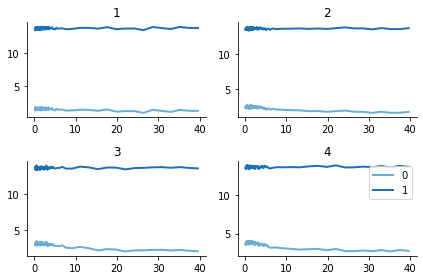

<Figure size 1440x720 with 0 Axes>

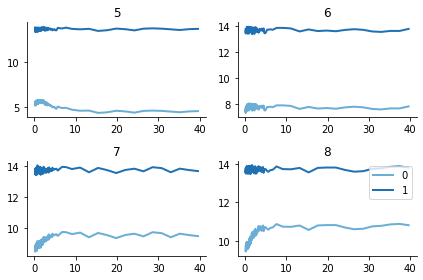

<Figure size 1440x720 with 0 Axes>

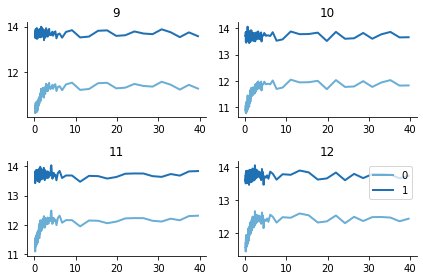

<Figure size 1440x720 with 0 Axes>

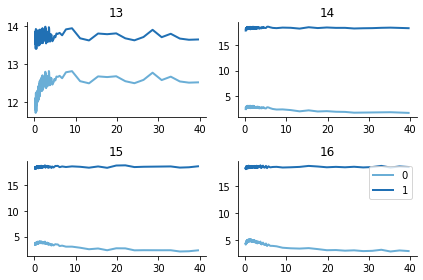

<Figure size 1440x720 with 0 Axes>

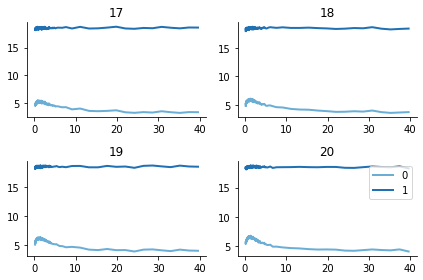

<Figure size 1440x720 with 0 Axes>

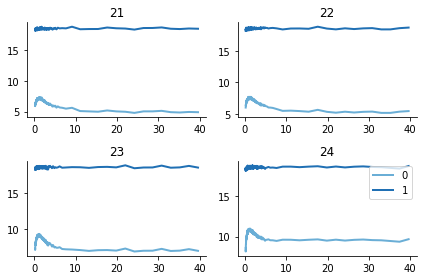

<Figure size 1440x720 with 0 Axes>

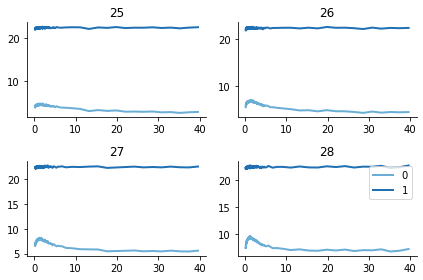

<Figure size 1440x720 with 0 Axes>

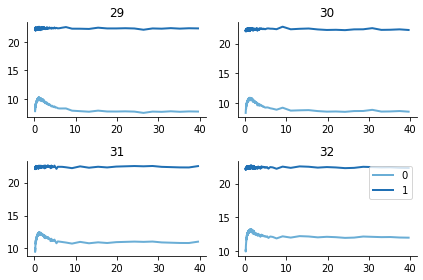

<Figure size 1440x720 with 0 Axes>

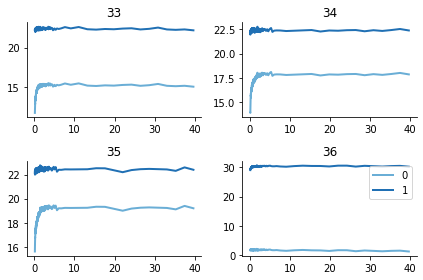

<Figure size 1440x720 with 0 Axes>

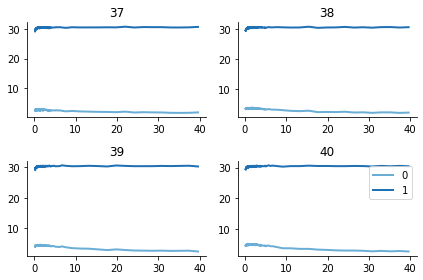

<Figure size 1440x720 with 0 Axes>

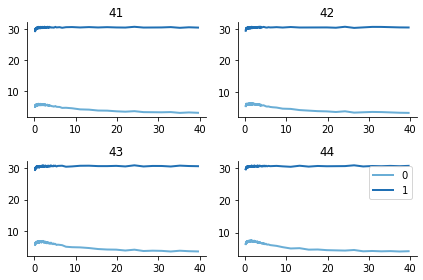

<Figure size 1440x720 with 0 Axes>

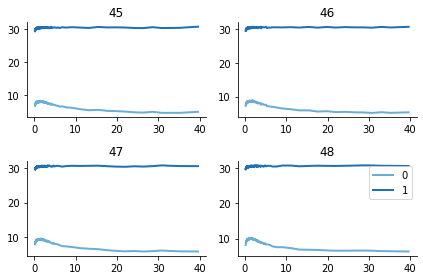

<Figure size 1440x720 with 0 Axes>

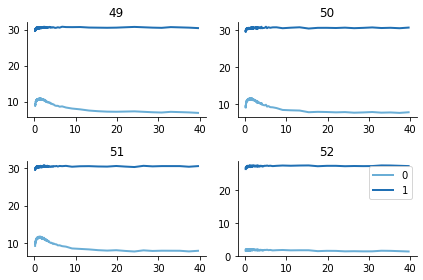

<Figure size 1440x720 with 0 Axes>

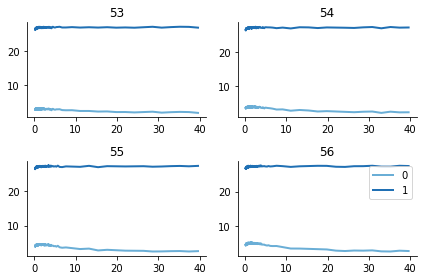

<Figure size 1440x720 with 0 Axes>

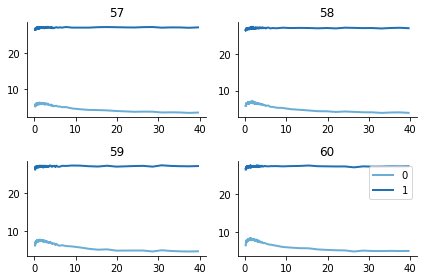

<Figure size 1440x720 with 0 Axes>

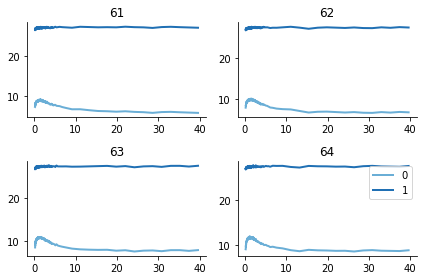

<Figure size 1440x720 with 0 Axes>

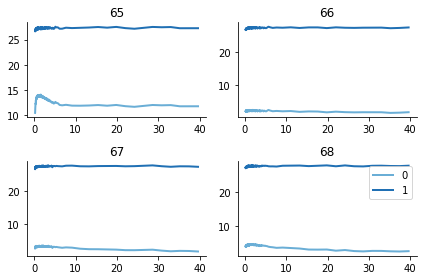

<Figure size 1440x720 with 0 Axes>

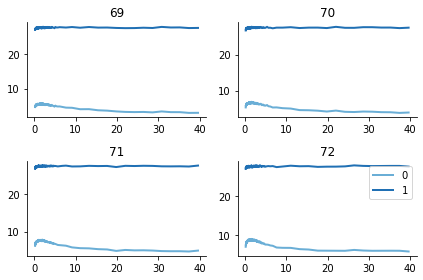

<Figure size 1440x720 with 0 Axes>

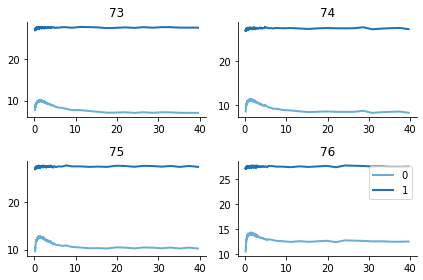

<Figure size 1440x720 with 0 Axes>

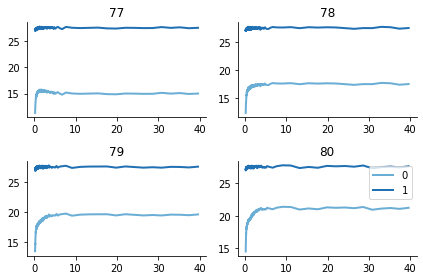

<Figure size 1440x720 with 0 Axes>

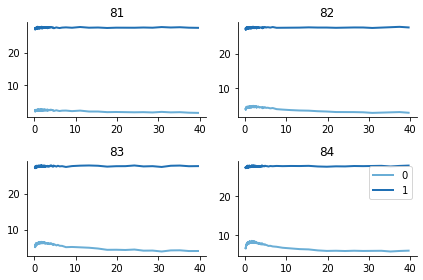

<Figure size 1440x720 with 0 Axes>

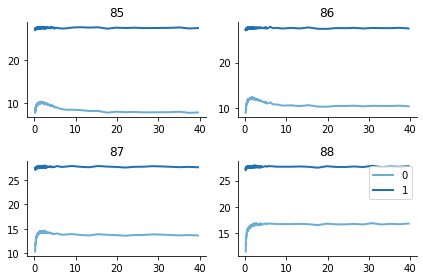

<Figure size 1440x720 with 0 Axes>

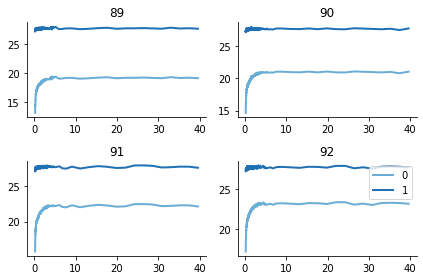

<Figure size 1440x720 with 0 Axes>

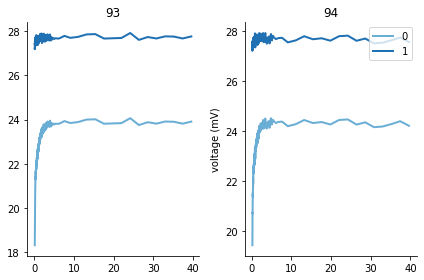

In [18]:
# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

# plotting
%matplotlib inline




for j in np.arange(92//4):
    plt.figure(figsize=(20,10))
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    for i in range(num_samples):
        ax1.plot(t,sim_samples[i,j*4,:],color=col1[i],lw=2, label = str(i))
        ax1.set_title(str(j*4+1))
        ax2.plot(t,sim_samples[i,j*4+1,:],color=col1[i],lw=2, label = str(i))
        ax2.set_title(str(j*4+2))
        ax3.plot(t,sim_samples[i,j*4+2,:],color=col1[i],lw=2, label = str(i))
        ax3.set_title(str(j*4+3))
        ax4.plot(t,sim_samples[i,j*4+3,:],color=col1[i],lw=2, label = str(i))
        ax4.set_title(str(j*4+4))
    plt.legend(loc="upper right")
    fig.tight_layout()
    
plt.figure(figsize=(20,10))
fig, (ax1, ax2) = plt.subplots(1, 2)        
for i in range(num_samples):
    ax1.plot(t,sim_samples[i,92,:],color=col1[i],lw=2, label = str(i))
    ax1.set_title(str(93))
    ax2.plot(t,sim_samples[i,93,:],color=col1[i],lw=2, label = str(i))
    ax2.set_title(str(94))
plt.ylabel('voltage (mV)')
plt.legend(loc="upper right")
fig.tight_layout()
plt.show()
#fig.set_xticks([])
#fig.set_yticks([-80, -20, 40])



As can be seen, the voltage traces can be quite diverse for different parameter values.

Often, we are not interested in matching the exact trace, but only in matching certain features thereof. In this example of the Hodgkin Huxley model, the summary features are the number of spikes, the mean resting potential, the standard deviation of the resting potential, and the first 4 voltage moments, mean, standard deviation, skewness and kurtosis. In the function `calculate_summary_statistics()` below, we compute these statistics from the output of the Hodgkin Huxley simulator. 

In [ ]:
from faas_helper_fns import calc_summ

Lastly, we define a function that performs all of the above steps at once. The function `simulation_wrapper` takes in conductance values, runs the Hodgkin Huxley model and then returns the summary statistics.

In [ ]:
def simulation_wrapper(params):
    """
    Takes in conductance values and then first runs the Hodgkin Huxley model and then returns the summary statistics as torch.Tensor
    """
    obs = run_faas_model(params)
    summstats = torch.as_tensor(calc_summ(d=obs))
    return summstats

`sbi` takes any function as simulator. Thus, `sbi` also has the flexibility to use simulators that utilize external packages, e.g., Brian (http://briansimulator.org/), nest (https://www.nest-simulator.org/), or NEURON (https://neuron.yale.edu/neuron/). External simulators do not even need to be Python-based as long as they store simulation outputs in a format that can be read from Python. All that is necessary is to wrap your external simulator of choice into a python callable that takes a parameter set and outputs a set of summary statistics we want to fit the parameters to.

## Checking summary statistics

In [ ]:
# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

# plotting
%matplotlib inline




for j in np.arange(1):
    plt.figure(figsize=(20,10))
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    for i in range(num_samples):
        ax1.plot(t,sim_samples[i,j*4,:],color=col1[i],lw=2, label = str(i))
        ax1.set_title(str(j*4+1))
        ax2.plot(t,sim_samples[i,j*4+1,:],color=col1[i],lw=2, label = str(i))
        ax2.set_title(str(j*4+2))
        ax3.plot(t,sim_samples[i,j*4+2,:],color=col1[i],lw=2, label = str(i))
        ax3.set_title(str(j*4+3))
        ax4.plot(t,sim_samples[i,j*4+3,:],color=col1[i],lw=2, label = str(i))
        ax4.set_title(str(j*4+4))
    plt.legend(loc="upper right")
    fig.tight_layout()
    
for i in range(num_samples):
    print(simulation_wrapper(params=params[i,:])[1][:5])

print(sim_samples[0,0,:])

## 3) Prior over model parameters

Now that we have the simulator, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:

In [ ]:
prior_max = np.array([12,  10, 12,  10, -3, -4, -4,-4] + [0.05,-0.5])
prior_min = np.array([4,  2, 4, 2, -10, -10, -10, -12] + [-0.05,-0.5])
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Coming back to the observed data
As mentioned at the beginning of the tutorial, the observed data are generated by the Hodgkin-Huxley model with a set of known parameters ($\bar g_{Na}$,$\bar g_K$). To illustrate how to compute the summary statistics of the observed data, let us regenerate the observed data:

In [ ]:
# true parameters and respective labels
true_params = np.array([8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01])       
labels_params = ['KonTN', 'KonTC', 'KonRN', 'KonRC', 'KDTN', 'KDTC', 'KDRN', 'KDRC', 'malpha', 'alpha0']

In [ ]:
observation_trace = run_faas_model(true_params)
observation_summary_statistics = torch.as_tensor(calc_summ(observation_trace))

As we had already shown above, the observed voltage traces look as follows:

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

t = observation_trace['time']
num_samples = 1
for j in np.arange(92//4):
    plt.figure(figsize=(20,10))
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.plot(t,observation_trace['data'][j*4,:],lw=2)
    ax1.set_title(str(j*4+1))
    ax2.plot(t,observation_trace['data'][j*4+1,:],lw=2)
    ax2.set_title(str(j*4+2))
    ax3.plot(t,observation_trace['data'][j*4+2,:],lw=2)
    ax3.set_title(str(j*4+3))
    ax4.plot(t,observation_trace['data'][j*4+3,:],lw=2)
    ax4.set_title(str(j*4+4))
    fig.tight_layout()
    
plt.figure(figsize=(20,10))
fig, (ax1, ax2) = plt.subplots(1, 2)        

ax1.plot(t,observation_trace['data'][92,:],lw=2)
ax1.set_title(str(93))
ax2.plot(t,observation_trace['data'][93,:],lw=2)
ax2.set_title(str(94))
plt.ylabel('voltage (mV)')
fig.tight_layout()
plt.show()


## Inference
Now that we have all the required components, we can run inference with SNPE. We start by importing our SNPE object of choice.

We now want to use SNPE to identify parameters whose activity matches this trace. To do so, we instantiate the SNPE object...

In [ ]:
snpe_common_args = dict(
    simulator=simulation_wrapper,
    x_o=observation_summary_statistics,
    prior=prior,
    simulation_batch_size=1,
)

... and run the inference.

In [ ]:
infer = SnpeC(sample_with_mcmc=False, **snpe_common_args)

# Run inference.
num_rounds, num_simulations_per_round = 1, 500
posterior = infer(
    num_rounds=num_rounds, num_simulations_per_round=num_simulations_per_round, batch_size=2
)

## Analysis of the results

After running the inference algorithm, let us inspect and analyse the results. It seems that the loss function has converged. Let us inspect the inferred posterior distribution over the parameters ($\bar g_{Na}$,$\bar g_K$)

In [ ]:
###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

In [ ]:
samples = posterior.sample(10000)

In [ ]:
fig, axes = utils.samples_nd(utils.tensor2numpy(samples),
                       limits=np.asarray([prior_min, prior_max]).T,
                       ticks=np.asarray([prior_min, prior_max]).T,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['GT']},
                       kde_offdiag={'bins': 50},
                       points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors='g',
                       title='');

As can be seen, the inferred posterior contains the ground-truth parameters (green) in a high-probability region. Now, let us sample parameters from the posterior distribution, simulate the Hodgkin-Huxley model for each of those samples and compare the simulations with the observed data:

In [ ]:
y_obs = observation_trace['data']
t = observation_trace['time']
duration = np.max(t)

num_samp = 2

# sample from posterior
x_samp = posterior.sample(num_samples=1000)

x_samp = np.median(x_samp.detach().numpy(), axis=0)

#x_samp = [ 7.682584,    5.845819,    8.078228,    6.199831,   -6.098556,   -6.454344,
# -6.7167273,  -8.592197,   -0.01400174, -0.0039]

#[8.886491e+00,  7.924279e+00,
#1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
#-6.585027e+00,  1.100000e-03, -3.900000e-01])

In [ ]:
fig = plt.figure(figsize=(7,5))

col_min = 1
num_colors = num_samp+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

# reject samples for which prior is zero
#ind = (x_samp > prior_min) & (x_samp < prior_max)
#params = x_samp[np.prod(ind,axis=1)==1]
params = x_samp
#num_samp = len(params[:,0])

# simulate and plot samples
post_samples = np.zeros((num_samp, 94 ,259))
post_samples = run_faas_model(params=params)['data']

    
for j in np.arange(92//4):
    plt.figure(figsize=(20,10))
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.plot(t,observation_trace['data'][j*4,:],lw=2)
    ax1.set_title(str(j*4+1))
    ax2.plot(t,observation_trace['data'][j*4+1,:],lw=2)
    ax2.set_title(str(j*4+2))
    ax3.plot(t,observation_trace['data'][j*4+2,:],lw=2)
    ax3.set_title(str(j*4+3))
    ax4.plot(t,observation_trace['data'][j*4+3,:],lw=2)
    ax4.set_title(str(j*4+4))

    #for i in range(num_samp):
    ax1.plot(t,post_samples[j*4,:],color=col1[0],lw=2, label = str(0))
    ax1.set_title(str(j*4+1))
    ax2.plot(t,post_samples[j*4+1,:],color=col1[0],lw=2, label = str(0))
    ax2.set_title(str(j*4+2))
    ax3.plot(t,post_samples[j*4+2,:],color=col1[0],lw=2, label = str(0))
    ax3.set_title(str(j*4+3))
    ax4.plot(t,post_samples[j*4+3,:],color=col1[0],lw=2, label = str(0))
    ax4.set_title(str(j*4+4))
    plt.legend(loc="upper right")
    fig.tight_layout()
    
plt.figure(figsize=(20,10))
fig, (ax1, ax2) = plt.subplots(1, 2)        

ax1.plot(t,observation_trace['data'][92,:],lw=2)
ax1.set_title(str(93))
ax2.plot(t,observation_trace['data'][93,:],lw=2)
ax2.set_title(str(94))

fig.tight_layout()
plt.show()

As can be seen, the samples from the inferred posterior lead to simulations that closely resemble the observed data, confirming that `SNPE-C` did a good job at capturing the observed data.

## References


A. L. Hodgkin and A. F. Huxley. A quantitative description of membrane current and its application to conduction and excitation in nerve. The Journal of Physiology, 117(4):500–544, 1952.

M. Pospischil, M. Toledo-Rodriguez, C. Monier, Z. Piwkowska, T. Bal, Y. Frégnac, H. Markram, and A. Destexhe. Minimal Hodgkin-Huxley type models for different classes of cortical and thalamic neurons. Biological Cybernetics, 99(4-5), 2008.